## Plots bond-stereocenter matrices for a give matrix-encoded synthetic route

In [1]:
from rdkit import Chem
from rdkit.Chem import Atom, BondType
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.colors import ListedColormap
plt.rcParams.update({'font.family':'Arial'})

import numpy as np
import numpy.ma as ma

import os
import re

In [2]:
# colormap for the bond tracker plot.
piyg_9 = plt.get_cmap('PiYG', 9)(np.arange(9))
piyg_short = piyg_9[[0,1,2,4,6,7,8]]
ggs = 0.9
piyg_short[0] = [ggs,ggs,ggs,1]
piyg_short[3] = [0,0,0,0]
piyg = ListedColormap(piyg_short)

In [3]:
bg = [0,0,0,0]

synthia_purple = np.array([80,50,145,255])/255
synthia_blue = np.array([45,190,205,255])/255
synthia_orange = np.array([255,160,0,255])/255
synthia_pink = np.array([235,60,150,255])/255

synthia_purple_cm = ListedColormap(np.array([bg,synthia_purple]))
synthia_blue_cm = ListedColormap(np.array([bg,synthia_blue]))
synthia_orange_cm = ListedColormap(np.array([bg,synthia_orange]))
synthia_pink_cm = ListedColormap(np.array([bg, synthia_pink]))

gg = 0.8
grey = [gg,gg,gg,1]
grey_cm = ListedColormap([bg,grey])

In [4]:
def molFromAdjMat(atoms, amat,sanitize=True):
    """
    Creates a mol object from an adjacency matrix.
    Inputs:
    atoms: list of atomic numbers of atoms, by row
    amat: adjacency matrix. Has to have same length as atoms (obviously)
    Output: mol object
    """
    
    m = Chem.RWMol()
    # add in the separate atoms
    for a in atoms: m.AddAtom(Atom(a))
    side_len = len(amat)    
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order = amat[r][c]
            if bond_order > 0:
                if bond_order == 1: m.AddBond(r,c,BondType.SINGLE)
                if bond_order == 2: m.AddBond(r,c,BondType.DOUBLE)
                if bond_order == 3: m.AddBond(r,c,BondType.TRIPLE)

    if sanitize:
        Chem.SanitizeMol(m)
    return m

In [5]:
def plot_amat_con(amat,core_atom_count,use_cmap,new_x=None,new_y=None):
    concession_mat = np.zeros(amat.shape)
    
    vmin,vmax = (-3.5,3.5)
    
    concession_mat[core_atom_count:,:] = -3
    concession_mat[:,core_atom_count:] = -3
    
    # various font sizes
    title_fontsize = 20
    grid_fontsize = 10
    ax_fontsize = 12
    cbar_fontsize = 12

    amat_len = amat.shape
    x = list(range(1,(amat.shape[1]+1)))
    y = list(range(1,(amat.shape[0]+1)))

    fig, ax = plt.subplots(figsize=(10,9))

    im2 = ax.imshow(concession_mat,cmap=use_cmap)
    im = ax.imshow(amat,cmap=use_cmap)

    ax.set_xticks(np.arange(len(x)))
    ax.set_yticks(np.arange(len(y)))

    if new_x is not None:
        ax.set_xticklabels(new_x,fontname='Arial',fontsize=ax_fontsize)
    else:
        ax.set_xticklabels(x,fontname='Arial',fontsize=ax_fontsize)
        
    if new_y is not None:
        ax.set_yticklabels(new_y,fontname='Arial',fontsize=ax_fontsize)
    else:
        ax.set_yticklabels(y,fontname='Arial',fontsize=ax_fontsize)    

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im2.set_clim(vmin,vmax)
    im.set_clim(vmin, vmax)
    cb = plt.colorbar(im, cax=cax)
    # Minor ticks
    ax.set_xticks(np.arange(-.5, amat.shape[1], 1), minor=True);
    ax.set_yticks(np.arange(-.5, amat.shape[0], 1), minor=True);

    gg = 0.8
    # Gridlines based on minor ticks
    ax.grid(which='minor', color=[gg,gg,gg,1], linestyle='-', linewidth=1)

    cb.ax.tick_params(labelsize=18)
    cb.set_ticks([-3,-2,-1,0,1,2,3])
    cb.ax.set_yticklabels(["concession",-2,-1,0,1,2,3],font="Arial",fontsize=cbar_fontsize)
    pass

In [6]:
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item

def sort_and_deduplicate(l):
    return list(uniq(sorted(l)))

In [7]:
def reorder_matrix(mat,new_order):
    return mat[new_order,:][:,new_order]

In [8]:
def setup_bond_tracker(amats,atoms):

    # set the core (target) atom count here
    final_mol = molFromAdjMat(atoms, amats[-1],sanitize=True)
    final_frag_sizes = [len(i) for i in Chem.GetMolFrags(final_mol)]
    core_atom_count = max(final_frag_sizes)
    
    # convert to only 1 and 0 for simpler plotting. Remove if required.
    # amats = (amats!=0).astype(int)
    
    fin_amat = amats[-1]
    fin_amat_core = fin_amat[:core_atom_count,:core_atom_count].copy()

    # this includes stereocenters
    # this is the x-y coords of the non-zero entries
    final_bonds = np.where(np.tril(fin_amat_core)!=0)
    n_pdt_entries = np.array(final_bonds).shape[1]

    # format into [r,c] pairs
    final_bond_pairs = np.vstack(final_bonds).transpose()
    final_bond_pairs = [list(i) for i in final_bond_pairs]
    
    
    # all bonds that ever existed throughout the whole route
    all_bonds_ever = []
    for a in amats:
        bonds = np.where(np.tril(a)!=0)
        bond_pairs = np.vstack(bonds).transpose()
        all_bonds_ever.extend([list(i) for i in bond_pairs])  
        
    # sort and clean up
    all_bonds_ever = sort_and_deduplicate(all_bonds_ever)
    
    concession_bonds = [i for i in all_bonds_ever if i not in list(final_bond_pairs)]
    
    # the final bond pairs stacked with concession bonds.
    # basically all_bonds_ever, but reordered, and transposed back to flat rectangle
    plot_bonds = np.vstack((final_bond_pairs,concession_bonds)).transpose()
    
    new_x = []

    for i in range(len(plot_bonds[0])):
        new_x.append(f"{plot_bonds[0][i]+1}\n{plot_bonds[1][i]+1}")

    bond_tracker = amats[:,plot_bonds[0],plot_bonds[1]]
    
    return {"bond_tracker":bond_tracker, "plot_bonds":plot_bonds, "n_pdt_entries":n_pdt_entries,
            "final_bond_pairs":final_bond_pairs, "bond_inds_list":new_x}

In [9]:
def make_masks(mask_shape,bond_tracker_output):
    
    bond_tracker = bond_tracker_output["bond_tracker"]
    plot_bonds = bond_tracker_output["plot_bonds"]
    n_pdt_entries = bond_tracker_output["n_pdt_entries"]
    
    purchased_bonds  = []
    strategic_bonds  = []
    concession_bonds = []

    for i in range(bond_tracker.shape[1]):
    #     print(i)
        bond_hist = bond_tracker[:,i]

        # purchased bond: nature does not change during route
        if i < n_pdt_entries and \
            ( all(bond_hist[0] == bond_hist) or all(bond_hist!=0) ):
            purchased_bonds.append((plot_bonds[0][i],plot_bonds[1][i]))
    #         print(f"{i+1}: ",plot_bonds[0][i]+1,plot_bonds[1][i]+1)

        # strategic: absent at beginning but present at the end.
        # this excludes bonds which are present at the end, but are between two concession atoms.

        elif i < n_pdt_entries and (bond_hist[0] == 0 and bond_hist[-1] != 0):
            strategic_bonds.append((plot_bonds[0][i],plot_bonds[1][i]))

        # concession bonds are everything else. 
        else:
            concession_bonds.append((plot_bonds[0][i],plot_bonds[1][i]))
            
            
    purchased_mask = np.zeros(mask_shape)
    concession_mask = np.zeros(mask_shape)
    strategic_mask = np.zeros(mask_shape)

    for i in purchased_bonds:
        purchased_mask[i] = 1
    purchased_mask += purchased_mask.transpose()
    purchased_mask = np.int8(purchased_mask == 0)

    for i in concession_bonds:
        concession_mask[i] = 1
    concession_mask += concession_mask.transpose()
    concession_mask = np.int8(concession_mask == 0)

    for i in strategic_bonds:
        strategic_mask[i] = 1
    strategic_mask += strategic_mask.transpose()
    strategic_mask = np.int8(strategic_mask == 0)

    return {"purchased_mask":purchased_mask,"concession_mask":concession_mask,"strategic_mask":strategic_mask}

In [10]:
def plot_amat(amat,masks,savename=None,plt_title=None):
    """
    still needs fontsizes defined globally.
    """

    # make the masked arrays of the intermediate's bonds

    p = ma.array(amat, mask=masks["purchased_mask"])
    s = ma.array(amat, mask=masks["strategic_mask"])
    c = ma.array(amat, mask=masks["concession_mask"])

    plt.figure(figsize=plt_figsize)
    ax = plt.gca()

    # plot the background and bonds
    ax.set_facecolor("black")

    p_plt = ax.imshow(p,cmap=synthia_pink_cm)
    s_plt = ax.imshow(s,cmap=grey_cm)
    c_plt = ax.imshow(c,cmap=synthia_blue_cm)

    atom_labels = range(1,len(amat)+1)

    for pl in [p_plt,s_plt,c_plt]:
        pl.set_clim(0,1)
    
    # plot the grey gridlines
    # set minor ticks and draw the grid
    ax.set_xticks(np.arange(-.5, amat.shape[1], 1), minor=True);
    ax.set_yticks(np.arange(-.5, amat.shape[0], 1), minor=True);

    gg = 0.7
    # Gridlines based on minor ticks
    ax.grid(which='minor', color=[gg,gg,gg,1], linestyle='-', linewidth=1)

    ax.set_xticks(np.arange(len(amat)))
    ax.set_yticks(np.arange(len(amat)))
    atom_labels = range(1,len(amat)+1)
    ax.set_xticklabels(atom_labels,font="Arial",fontsize=fs,rotation=0)
    ax.set_yticklabels(atom_labels,font="Arial",fontsize=fs)
    plt.tight_layout()
    if plt_title:
        plt.title(plt_title,fontsize=title_fs)
    if savename:
        plt.savefig(savename,dpi=300,format="svg")
    pass

## note

Due to the font adjustments required for each route, only one route's matrices are plotted below.

To plot other route, change the route_name variable to point to the desired matrix file.

In [11]:
route_name = "stemo_synthia_mannich"
matrix_path = f"./matrices/{route_name}.npz"


data = np.load(matrix_path)
amats = data["amats"]
atoms = [int(i) for i in data["atoms"]] # RDKit doesn't like arrays for some reason.
mask_shape=amats.shape[1:]

bond_tracker = setup_bond_tracker(amats,atoms)
masks = make_masks(mask_shape,bond_tracker)

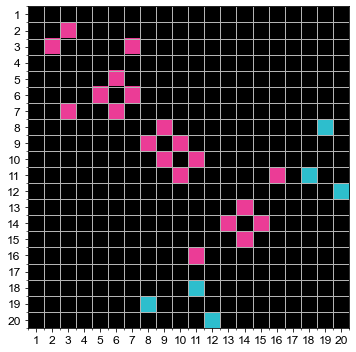

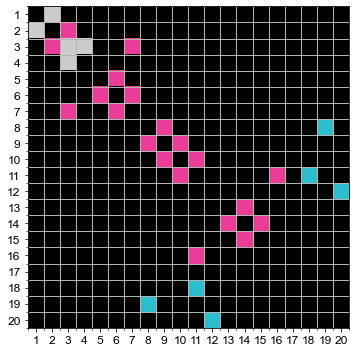

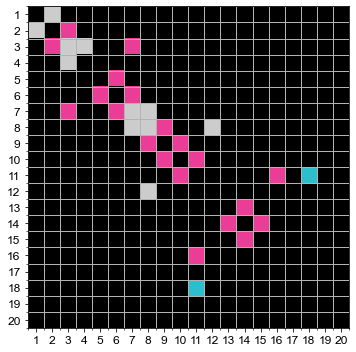

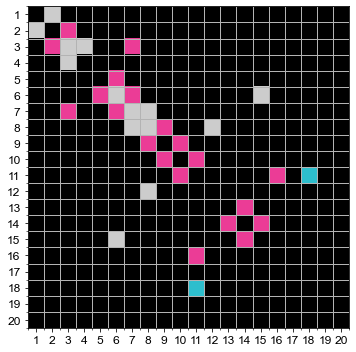

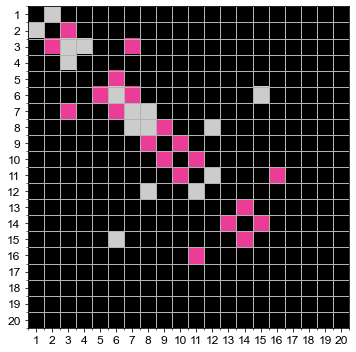

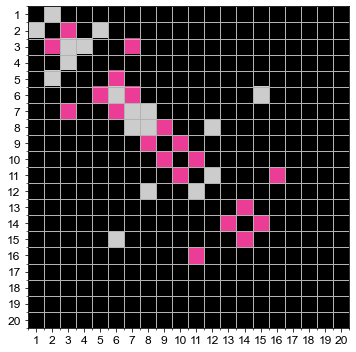

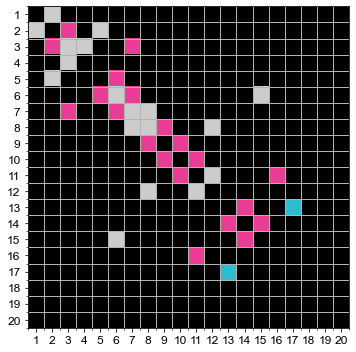

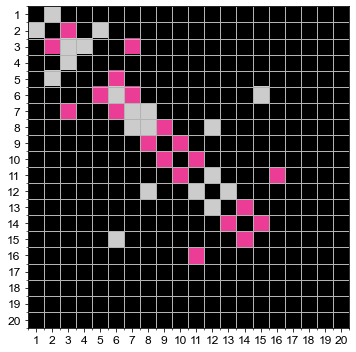

In [12]:
# plot.
fs = 12
title_fs = 30
plt_figsize=(5,5)
if not os.path.isdir(f"./matrix_plots/{route_name}/"):
    os.makedirs(f"./matrix_plots/{route_name}/")
for ia, amat in enumerate(amats):
    savename = f"./matrix_plots/{route_name}/{route_name}_{ia+1}.svg"
#     print(savename)
#     savename=None
    plot_amat(amat,masks,savename=savename,plt_title=None)

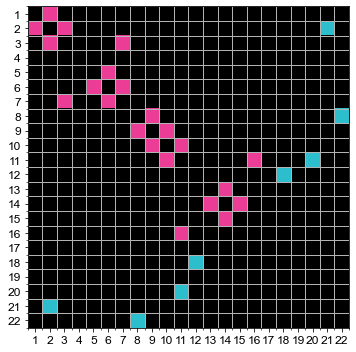

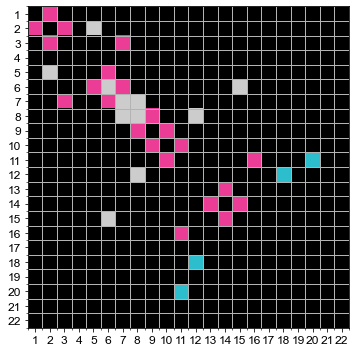

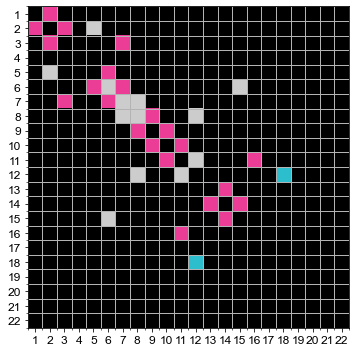

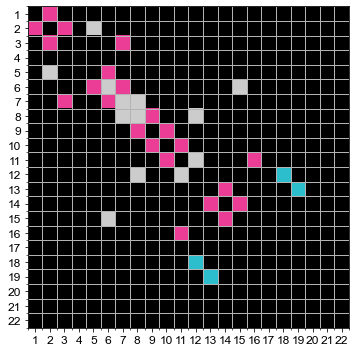

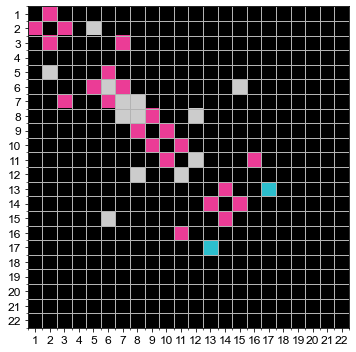

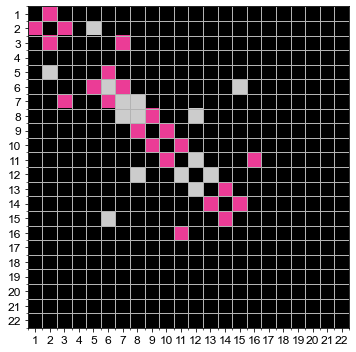

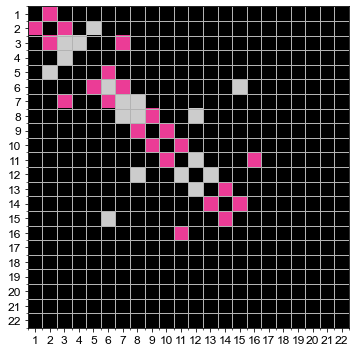

In [13]:
route_name = "stemo_exp_mannich"
matrix_path = f"./matrices/{route_name}.npz"


data = np.load(matrix_path)
amats = data["amats"]
atoms = [int(i) for i in data["atoms"]] # RDKit doesn't like arrays for some reason.
mask_shape=amats.shape[1:]

bond_tracker = setup_bond_tracker(amats,atoms)
masks = make_masks(mask_shape,bond_tracker)

# plot.
fs = 12
title_fs = 30
plt_figsize=(5,5)
if not os.path.isdir(f"./matrix_plots/{route_name}/"):
    os.makedirs(f"./matrix_plots/{route_name}/")
for ia, amat in enumerate(amats):
    savename = f"./matrix_plots/{route_name}/{route_name}_{ia+1}.svg"
#     print(savename)
#     savename=None
    plot_amat(amat,masks,savename=savename,plt_title=None)

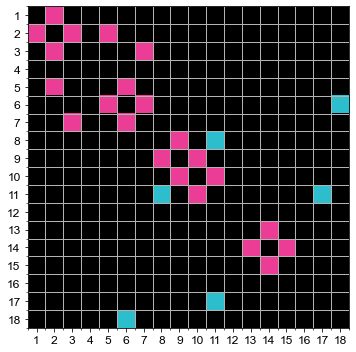

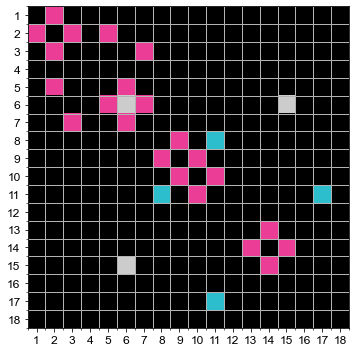

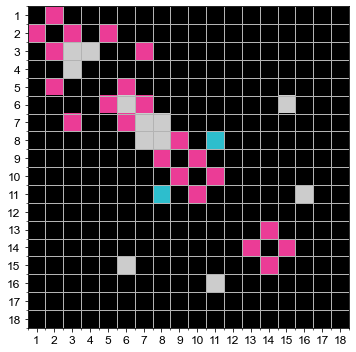

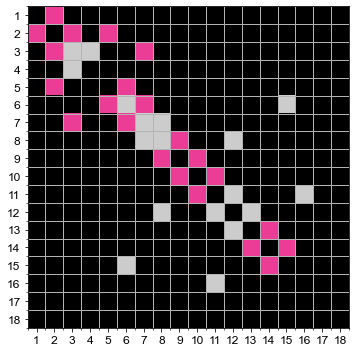

In [14]:
route_name = "stemo_exp_schmidt"
matrix_path = f"./matrices/{route_name}.npz"


data = np.load(matrix_path)
amats = data["amats"]
atoms = [int(i) for i in data["atoms"]] # RDKit doesn't like arrays for some reason.
mask_shape=amats.shape[1:]

bond_tracker = setup_bond_tracker(amats,atoms)
masks = make_masks(mask_shape,bond_tracker)

# plot.
fs = 12
title_fs = 30
plt_figsize=(5,5)
if not os.path.isdir(f"./matrix_plots/{route_name}/"):
    os.makedirs(f"./matrix_plots/{route_name}/")
for ia, amat in enumerate(amats):
    savename = f"./matrix_plots/{route_name}/{route_name}_{ia+1}.svg"
#     print(savename)
#     savename=None
    plot_amat(amat,masks,savename=savename,plt_title=None)